### Introduction ###

There are four decoders included in the **replay_trajectory_classification** package:
+ `SortedSpikesDecoder`
+ `ClusterlessDecoder`
+ `SortedSpikesClassifier`
+ `ClusterlessClassifier`.

You can import them for use by running the following lines of code:

In [1]:
from replay_trajectory_classification import (SortedSpikesDecoder, ClusterlessDecoder,
                                              SortedSpikesClassifier, ClusterlessClassifier)

If `Decoder` is in the name it indicates that a single movement model is used to decode position.

If `Classifier` is in the name it means that multiple movement models are used to decode position and classify the type of movement.

`SortedSpikes` and `Clusterless` indicate the type of data the decoder uses:
+ `SortedSpikes` means the decoder takes in clustered single unit data.
+ `Clusterless` means the decoder takes in unsorted multiunit spikes and associated spike waveform features---like those that would usually be used to spike sort such as spike width, spike amplitude, etc.


Next, we will explore the expected data format for `SortedSpikes` and `Clusterless` decoders in turn. The both the `Decoder` and `Classifier` take the same data format.

### Sorted Spikes Data Format ###

We can see from the docstring of the fit function of `SortedSpikesDecoder` that there are two main variables that are required:
+ **position** - the 1D or 2D position of the animal at each time bin
+ **spikes** - 0 if there is no spike and 1 if there is a spike for each cell for each time bin

**NOTE**: Time bins should be small (typically 1 or 2 ms)

In [2]:
SortedSpikesDecoder.fit?

Signature:
SortedSpikesDecoder.fit(
    self,
    position,
    spikes,
    is_training=None,
    is_track_interior=None,
    track_graph=None,
    center_well_id=None,
    edge_order=None,
    edge_spacing=15,
)
Docstring:
Parameters
----------
position : ndarray, shape (n_time, n_position_dims)
spikes : ndarray, shape (n_time, n_neurons)
is_training : None or bool ndarray, shape (n_time), optional
    Time bins to be used for encoding.
is_track_interior : None or bool ndaarray, shape (n_x_bins, n_y_bins)
track_graph : networkx.Graph
center_well_id : object
edge_order : array_like
edge_spacing : None, float or array_like

Returns
-------
self
File:      ~/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/decoder.py
Type:      function


#### Example Data #### 
Let's look at some simulated data to get an intuition for these data types. We simulate spikes of 19 cells with 360,000 time bins (360 seconds) of data:

In [3]:
from replay_trajectory_classification.sorted_spikes_simulation import make_simulated_run_data

time, position, sampling_frequency, spikes, place_fields = make_simulated_run_data()

We can see that this numpy array is a matrix with time bins in the first dimension and cells on the second dimension

In [4]:
spikes.shape

(360000, 19)

and that there is a 1 each time a cell spikes and a 0 each time there is not a spike. For example, for the first cell, there is only one spike at 17 ms in the first 100 ms of time:

In [5]:
spikes[:100, 0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

We can visualize the spikes as a spike raster:

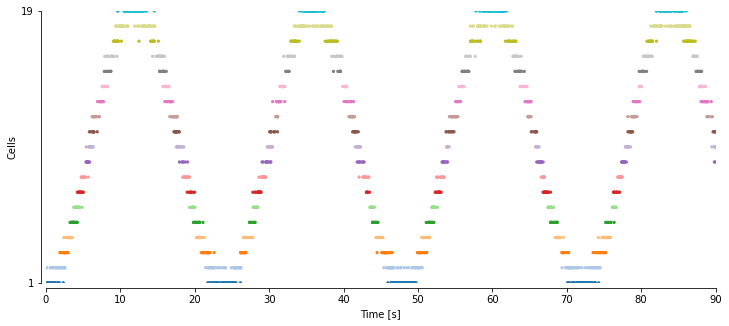

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 5))
spike_ind, neuron_ind = np.nonzero(spikes)
cmap = plt.get_cmap('tab20')

c = [cmap.colors[ind] for ind in neuron_ind]
ax.scatter(time[spike_ind], neuron_ind + 1, c=c, s=5)
ax.set_yticks((1, spikes.shape[1]))
ax.set_ylim((1, spikes.shape[1]))
ax.set_ylabel('Cells')

ax.set_xlabel('Time [s]')
ax.set_xlim((0.0, 90.0))
sns.despine(offset=5)

We also have a position variable which has the same number of time points and has one position dimension:

In [7]:
position.shape

(360000,)

We can plot position over time:

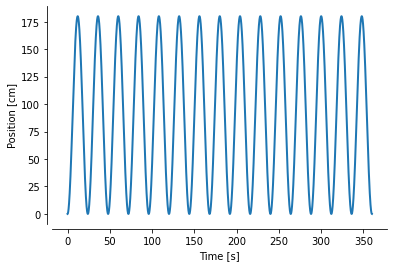

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(time, position, linewidth=2)
ax.set_ylabel("Position [cm]")
ax.set_xlabel("Time [s]")
sns.despine(offset=5)

#### Summary ####
So we have two numpy arrays that contain the data we need to fit and evaluate the model:

In [9]:
spikes.shape

(360000, 19)

In [10]:
position.shape

(360000,)

### Clusterless Data Format ###

The `Clusterless` decoders take the same information as the `SortedSpikes` decoders with one exception: the actual multiunit spikes and their associated waveform features. This variable is called **multiunits** and it has time bins on the first dimension, the marks (or associated wave form features) in the second dimension, and the electrodes in the last dimension.

In [11]:
ClusterlessDecoder.fit?

Signature:
ClusterlessDecoder.fit(
    self,
    position,
    multiunits,
    is_training=None,
    is_track_interior=None,
    track_graph=None,
    center_well_id=None,
    edge_order=None,
    edge_spacing=15,
)
Docstring:
Parameters
----------
position : array_like, shape (n_time, n_position_dims)
multiunits : array_like, shape (n_time, n_marks, n_electrodes)
is_training : None or array_like, shape (n_time,)
is_track_interior : None or ndarray, shape (n_x_bins, n_y_bins)
track_graph : networkx.Graph
center_well_id : object
edge_order : array_like
edge_spacing : None, float or array_like

Returns
-------
self
File:      ~/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/decoder.py
Type:      function


#### Example Data ####

For the multiunits array, if there is no spike in a particular time bin, there are only NaNs. If there is a spike, then the values of the associated waveform feature are filled in. Let's loook at some example simulated data:

In [12]:
from replay_trajectory_classification.clusterless_simulation import make_simulated_run_data

(time, position, sampling_frequency,
 multiunits, _) = make_simulated_run_data()

We can see that there are 350,000 time bins, 4 mark dimensions (wave form features), and 5 electrodes:

In [13]:
multiunits.shape

(350000, 4, 5)

If we look at the first electrode, we see that there is a spike in the first time bin and then no spike for the next 9 time bins (hence they are filled with NaNs):

In [14]:
multiunits[:10, :, 0]

array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]])

These four values represent waveform features of this electrode at the time of the spike. Likewise, if we look at the second electrode, we can see that there was no spike in the first 10 time bins.

In [15]:
multiunits[:10, :, 1]

array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]])

### Track Graph ###